# Machine learning tools for dimensionality reduction: PCA and clustering

When using battery-constrained sensors, one wants to reduce the amount of information to be transmitted - to save energy resources - while guaranteeing the correct recovery of the data at the receiver end. This is achieved through the implementation of dimensionality reduction tools that extract and retain the most relevant information from the data. In this notebook, you will implement and evaluate different approaches for dimensionality reduction using PCA and clustering. You will become familiar with  DBSCAN and you will implement the clustering following two different approaches (i.e., cluster the raw signals or some relevant features extracted from the signals).

In summary, in this notebook, you will:
1. implement the principal component analysis (PCA) algorithm from scratch
2. use the PCA and DBSCAN functions provided by Python developers through the scikit-learn library
3. apply the algorithms to ECG signals
4. evaluate the efficacy of the dimensionality reduction through PCA and clustering

Complete the notebook by substituting the `None` with the correct statements.

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/ACADEMIA/ML4HD_LABS/Lab_1/'

Mounted at /content/drive
/content/drive/MyDrive/ACADEMIA/ML4HD_LABS/Lab_1


## Import statements
IMPORTANT: `ModuleNotFoundError` usually means you miss some packets. Install them with `pip` as shown below.

In [6]:
!pip install kneebow
!pip install py-ecg-detectors
!pip install EntropyHub

  Preparing metadata (setup.py) ... done
  Created wheel for kneebow: filename=kneebow-1.0.4-py3-none-any.whl size=4815 sha256=a1641c37ee9fa9c910f9f4200bc8e0e797592022b02d41e537f4b04d2b4f3e49
  Stored in directory: /root/.cache/pip/wheels/48/38/6b/5fdbc5f148777490045bdb030aad2f591c6c72e2f3c3b719e6
Successfully built kneebow
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43804 sha256=600786ccce8fc1d74b16418fb4110f69714c9fbc13d84647755ad66476b56e42
  Stored in directory: /root/.cache/pip/wheels/b5/56/88/04643e9be584a6018e10aae5789d98225995da3e89513c3f30
Successfully built gatspy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
# Scientific packages
import numpy as np
import scipy
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from kneebow.rotor import Rotor
from scipy.io import loadmat
from scipy.signal import medfilt

from scipy.signal import resample

# Plot packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Custom functions
from hda_utils import load_dataset, load_dataset_DBSCAN, segment_ECG, segment_ECG2, matrix_to_signal

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,10]
np.random.seed(1)

## Load and visualize the ECG signal we will use

In [8]:
# Load signal
ecg_signal = load_dataset()

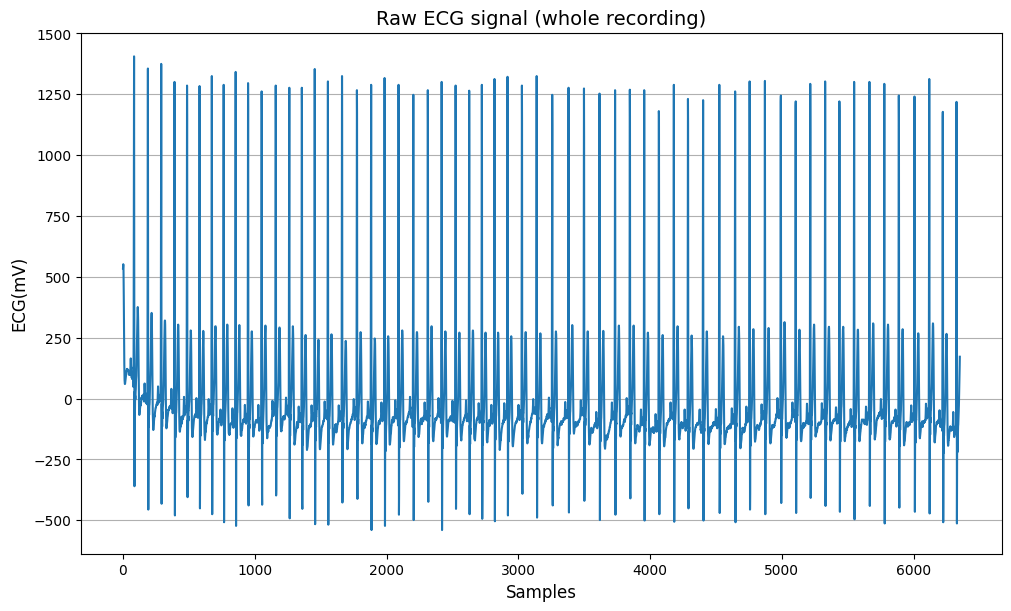

In [9]:
# Plot
fig = plt.figure(figsize=(10,6), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])

ax1.plot(ecg_signal)
ax1.set_title('Raw ECG signal (whole recording)', fontsize=14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('ECG(mV)', fontsize=12)
ax1.grid(axis='y')

plt.show()

## ECG segmentation

At this point, we need to implement a way to segment the signal into beats.

<img src="https://drive.google.com/uc?export=view&id=1tZtPoQbDHjAD0U3rzJx8k9Ogc8HGz7YR" style="width:800px;">
<caption><center> <u> Figure 1 </u>: one heart beat extracted from the ECG signal</center></caption>

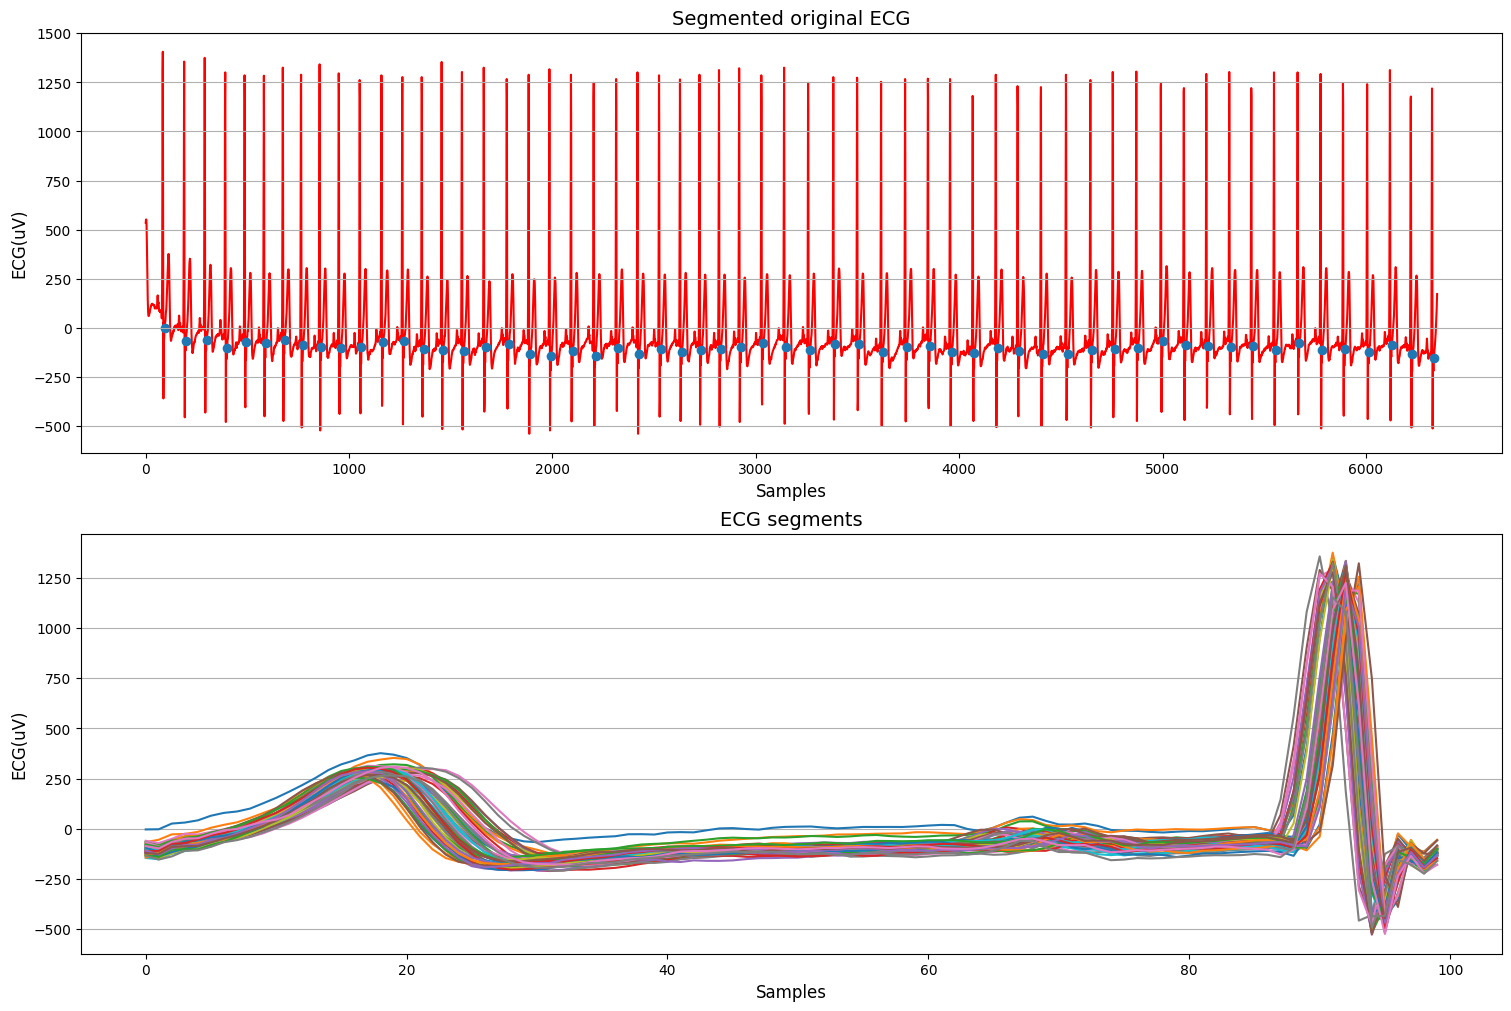

In [10]:
# ECG segmentation
fs = 130
ecg_mat, r_peaks, original_len = segment_ECG(ecg_signal, fs)


# Plot segments
fig1 = plt.figure(constrained_layout=True)
gs = GridSpec(2, 1, figure=fig1)
ax1 = fig1.add_subplot(gs[0, :])
ax2 = fig1.add_subplot(gs[1, :])

ax1.plot(ecg_signal, 'r', zorder = 0 )
ax1.scatter(r_peaks, list(ecg_signal[r_peaks].T[0]), zorder = 1)
ax1.set_title('Segmented original ECG', fontsize=14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('ECG(uV)', fontsize=12)
ax1.grid(axis='y')

ax2.plot(ecg_mat.T)
ax2.set_title('ECG segments', fontsize=14)
ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('ECG(uV)', fontsize=12)
ax2.grid(axis='y')

plt.show()

Next, an important step of data preprocessing for machine learning algorithms is normalization.
Here we use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class in Python that provides functions to normalize the data. In the following cell, normalize the ECG data by using the `StandardScaler().fit(ecg_mat)` and `scaler.transform(ecg_mat)`.

In [11]:
# Normalize data along feature axis (2 lines of code)
scaler = StandardScaler()
ecg_mat_norm = scaler.fit_transform(ecg_mat)
ecg_mat_norm

array([[ 3.98036093,  4.43134659,  4.53519659, ...,  0.3448648 ,
         2.52529052,  2.34174565],
       [ 1.39085877,  2.30752829,  2.33026144, ...,  0.78512674,
         2.42821873,  2.40181403],
       [ 1.59420426,  1.23122179,  1.16212945, ..., -1.1509963 ,
         1.23201615,  1.12222217],
       ...,
       [-0.84308877, -0.53974784, -0.24768555, ...,  0.65999345,
         0.59520741,  1.32034085],
       [ 0.60259598,  0.55157219,  0.7790709 , ..., -0.48863373,
        -1.9142797 , -2.35946611],
       [-1.34370518, -1.71367489, -2.19134023, ..., -1.74529744,
        -2.01328604, -1.65454541]])

Use the [train_test_split](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html) function to split the dataset into train and test sets. The dataset is composed of `ecg_mat_norm` and `original_len`. The `train_size` should be set to the value of `train_fraction` defined below, and `shuffle = False`.

In [12]:
# Split data
train_fraction = 0.8

ecg_mat_train, ecg_mat_test, original_len_train, original_len_test = train_test_split(ecg_mat_norm, original_len, train_size = train_fraction, random_state=42, shuffle=False)

## 1 - Principal component analysis (PCA)

The goal of PCA is to project the data in dataset $X \in \mathbb{R}^{n \times m}$ into a new space where the basis vectors are ordered based on their relevance in defining the data. The new basis is obtained as a linear combination of the vectors in the original basis, and the dataset after applying PCA $Y \in \mathbb{R}^{n \times m}$ is obtained as $Y=XP$ where $P \in \mathbb{R}^{m \times m}$ is the transformation matrix.

After performing PCA, we can retain a lower number of basis vectors $d < m$ to reduce the dimensionality of the dataset (for data compression purposes). The transformation matrix for this is defined by $W \in \mathbb{R}^{m \times d}$ and $\hat{Y}=XW$.

The PCA allows selecting the most important components to be retained for this purpose (as they are ordered), minimizing the mean square error between $\hat{X} = \hat{Y}\hat{W}$ and $X$, where $\hat{W} \in \mathbb{R}^{d \times m}$ is the matrix of reverse transformation ($\hat{W} = W^T$). In geometric terms, we want to find $d$ axes along which most of the variance occurs.

### 1a - implement your own dimensionality reduction algorithm based on PCA
The steps are the following:
1. normalize the data (in our case, already done above by StandardScaler)
2. compute the covariance matrix using the [`cov` function](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) of the numpy library: take a look at the `rowvar` argument to properly compute the covariance (in our case the rows of the matrix are the observations and the columns represent the variables/features)
3. perform eigen decomposition using the [`linalg.eigh` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html#scipy-linalg-eigh) of the scipy library: the function returns the eigenvectors and eigenvalues sorted based on the value of the eigenvalues
4. select the `num_components` strongest eigenvectors to be retained

The steps until here allow creating the model for dimensionality reduction through PCA. The training data is used to make the model learn which are the components of the data and their relevance in the definition of the data.

Once the model has been trained through steps 2-4, it can be used in real-time to process new data and obtain a compression version of it. The compressed data is built by retaining the strongest components found through PCA. As stated before, this compression step can be helpful when data needs to be transmitted over a communication system and we want to reduce the amount of information to send for different reasons such as latency, battery constraints, or network congestion issues. Therefore, the last step is to
5. apply the transformation to the test data (to be transmitted, i.e., at the transmitter side) and go back to the original reference system (at the receiver side) through the mathematical transformations above.

Complete the following function by substituting the `None` with the correct statements.

NOTE: In this example we have 100 features (length of a sample) and 46 samples. This means that the number of relevant components will be maximum 46 (that is the minimum between the number of samples and the number of features).

In [13]:
def my_PCA(X_train, X_test, num_components, scaler, original_len = None):

    # Use train data here
    covariance_mat = np.cov(X_train, rowvar=False)
    eigenvalues, eigenvectors = scipy.linalg.eigh(covariance_mat)
    sorted_indeces = np.flip(np.argsort(eigenvalues))
    P = eigenvectors[:, sorted_indeces]
    print(P.shape)
    # Keep only num_components dimensions
    W = P[:, :num_components]

    # Use test data here
    Y_hat = X_test @ W
    W_hat = np.transpose(W)
    X_hat = Y_hat @ W_hat

    approx_data = scaler.inverse_transform(X_hat)
    ecg_sig_rec = matrix_to_signal(approx_data, original_len)

    return ecg_sig_rec

Here we apply PCA to the test set and reconstruct the signal considering different numbers of components for the dimansionality reduction. Next, we plot the reconstruction of the test set with the different numbers of components. We plot in orange the original signal and in blue the reconstruction after PCA with dimensionality reduction. Note that the reconstruction is done only on the test set as it is the one that can be used for performance evaluation (as it was not used during training).

In [14]:
# No compression
n_components_nocomp = min(ecg_mat_train.shape[0], ecg_mat_train.shape[1])
ecg_sig_nocomp = my_PCA(ecg_mat_train, ecg_mat_test, n_components_nocomp, scaler, original_len_test)

# Compressed signal
n_components_comp1 = 3
ecg_sig_comp1 = my_PCA(ecg_mat_train, ecg_mat_test, n_components_comp1, scaler, original_len_test)

# More compressed signal
n_components_comp2 = 1
ecg_sig_comp2 = my_PCA(ecg_mat_train, ecg_mat_test, n_components_comp2, scaler, original_len_test)

(100, 100)
(100, 100)
(100, 100)


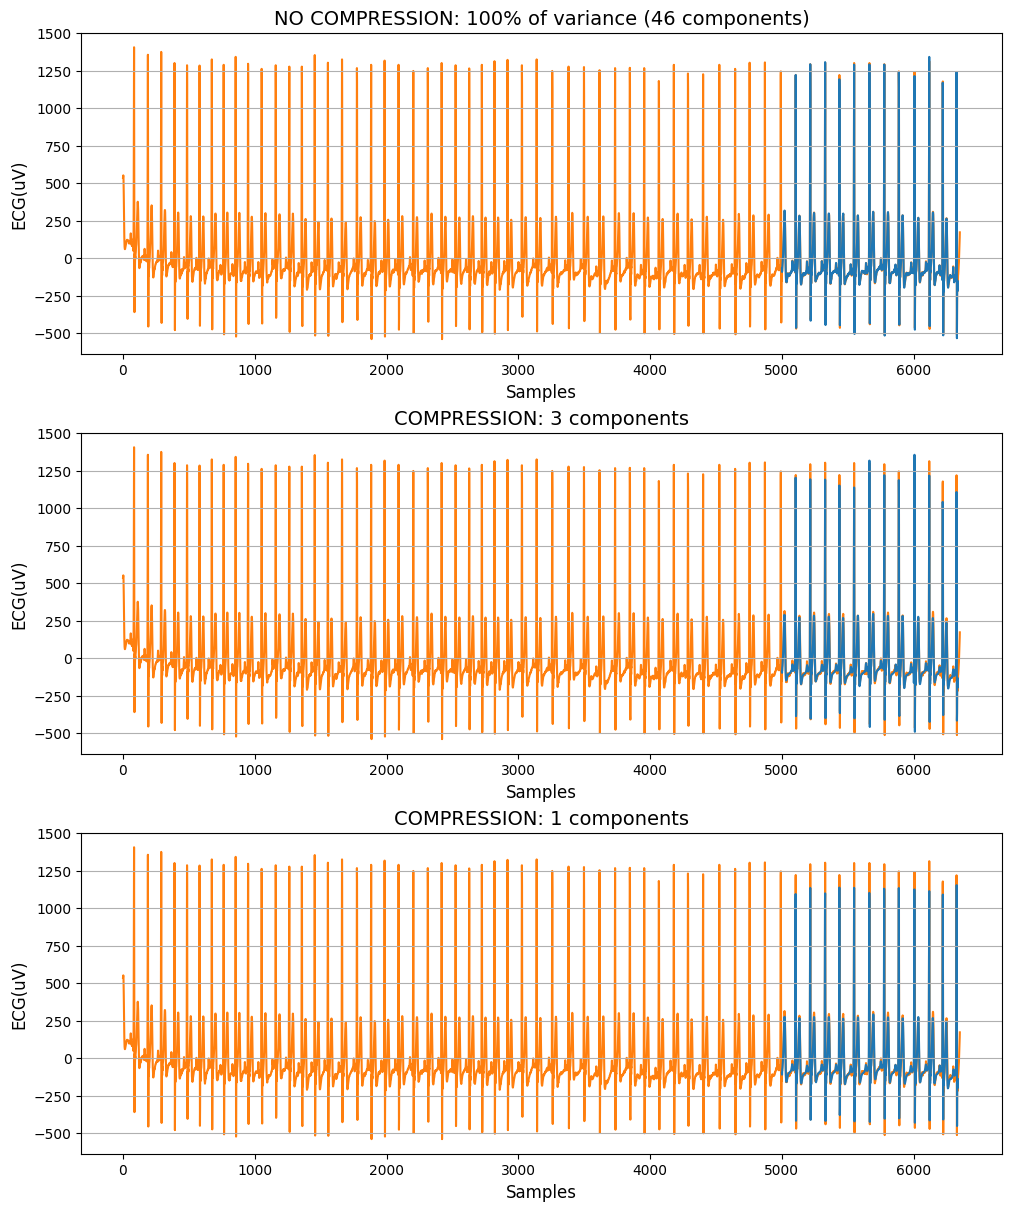

In [15]:
# Vector to select only test data from original signal
x_axis = np.arange(r_peaks[int(np.floor(len(r_peaks)*train_fraction))-1],r_peaks[-1], 1)

fig2 = plt.figure(figsize=(10,12), constrained_layout=True)
gs = GridSpec(3, 1, figure=fig2)
ax1 = fig2.add_subplot(gs[0, :])
ax2 = fig2.add_subplot(gs[1, :])
ax3 = fig2.add_subplot(gs[2, :])

# No compression
ax1.plot(x_axis, ecg_sig_nocomp, zorder = 1)
ax1.plot(ecg_signal, zorder = 0)
ax1.set_title('NO COMPRESSION: 100% of variance (' + str(n_components_nocomp) + ' components)', fontsize = 14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('ECG(uV)', fontsize=12)
ax1.grid(axis='y')

# Compressed signal
ax2.plot(x_axis, ecg_sig_comp1, zorder = 1)
ax2.plot(ecg_signal, zorder = 0)
ax2.set_title('COMPRESSION: ' + str(n_components_comp1) + ' components', fontsize = 14)
ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('ECG(uV)', fontsize=12)
ax2.grid(axis='y')

# More compressed signal
ax3.plot(x_axis, ecg_sig_comp2, zorder = 1)
ax3.plot(ecg_signal, zorder = 0)
ax3.set_title('COMPRESSION: ' + str(n_components_comp2) + ' components', fontsize = 14)
ax3.set_xlabel('Samples', fontsize=12)
ax3.set_ylabel('ECG(uV)', fontsize=12)
ax3.grid(axis='y')

plt.show()

### 1b - use the PCA dimensionality reduction algorithm from Python developers
Use the [sklearn.decomposition.PCA class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from the scikit-learn library. The steps are the following:
1. import the library (already done, see the "Import statements" section above)
2. create a new object of the class with `PCA(...)`: using this class you can specify the number of components to retain (as you did with `my_PCA` function) or the explainable variance (take a look at the documentation!). In this part of the notebook, you will specify the **explainable variance** you want to retain.
3. fit the PCA model on the data $X$ using the [fit method](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit): this provides you with $Y$ being the new representation of $X$ using a new basis. Use: `pca.fit(X_train)`

As already mentioned above, the steps until here are necessary to create the model and hence are performed using the training data.

At this point, we can use the built model to compress new data (test data):
4. compress the test data using the compressed PCA transformation with the [transform method](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform). Use: `pca.transform(X_test)`
5. go back to the original space using the [inverse_transform method](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.inverse_transform). Use: `pca.inverse_transform(Y_hat)`

In [26]:
def PCA_variancefraction(X_train, X_test, scaler, original_len_test, variance_fraction = None):
    # Create a PCA model with the required explained variance
    assert variance_fraction is None or (variance_fraction > 0 and variance_fraction < 1)
    pca = PCA(n_components=variance_fraction, svd_solver="full")
    # Fit the model to the train data
    pca.fit(X_train)

    # obtain the number of components
    n_components = int(pca.n_components_)

    # Transform the test data
    Y_hat = pca.transform(X_test)
    # Go back to original space
    X_hat = pca.inverse_transform(Y_hat)

    approx_data = scaler.inverse_transform(X_hat)
    ecg_sig_rec = matrix_to_signal(approx_data, original_len_test)

    return ecg_sig_rec, n_components

In [27]:
# Use the function considering two values as example for the variance
variance_fractions = [.95, .80]

# No compression
ecg_sig_nocomp, n_components_nocomp = PCA_variancefraction(ecg_mat_train, ecg_mat_test, scaler, original_len_test, None)

# Compressed signal
ecg_sig_comp1, n_components_comp1 = PCA_variancefraction(ecg_mat_train, ecg_mat_test, scaler, original_len_test,  variance_fractions[0])

# More compressed signal
ecg_sig_comp2, n_components_comp2 = PCA_variancefraction(ecg_mat_train, ecg_mat_test, scaler, original_len_test, variance_fractions[1])

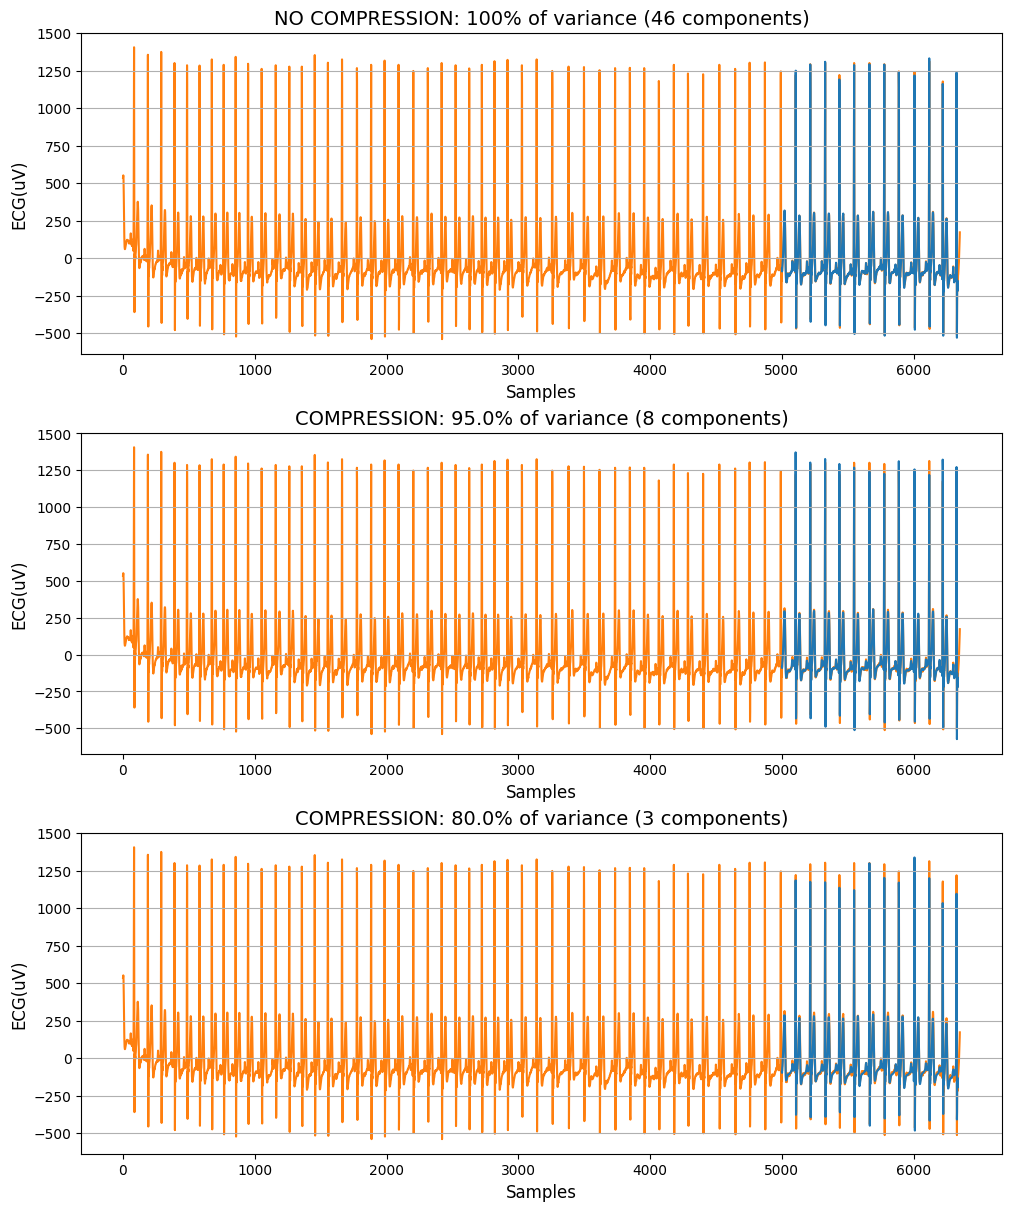

In [28]:
fig2 = plt.figure(figsize=(10,12), constrained_layout=True)
gs = GridSpec(3, 1, figure=fig2)
ax1 = fig2.add_subplot(gs[0, :])
ax2 = fig2.add_subplot(gs[1, :])
ax3 = fig2.add_subplot(gs[2, :])

# No compression
ax1.plot(x_axis, ecg_sig_nocomp, zorder = 1)
ax1.plot(ecg_signal, zorder = 0)
ax1.set_title('NO COMPRESSION: 100% of variance (' + str(n_components_nocomp) + ' components)', fontsize = 14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('ECG(uV)', fontsize=12)
ax1.grid(axis='y')

# Compressed signal
ax2.plot(x_axis,ecg_sig_comp1, zorder = 1)
ax2.plot(ecg_signal, zorder = 0)
ax2.set_title('COMPRESSION: ' + str(variance_fractions[0]*100) + '% of variance (' + str(n_components_comp1) + ' components)', fontsize = 14)
ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('ECG(uV)', fontsize=12)
ax2.grid(axis='y')

# More compressed signal
ax3.plot(x_axis, ecg_sig_comp2, zorder = 1)
ax3.plot(ecg_signal, zorder = 0)
ax3.set_title('COMPRESSION: ' + str(variance_fractions[1]*100) + '% of variance (' + str(n_components_comp2) + ' components)', fontsize = 14)
ax3.set_xlabel('Samples', fontsize=12)
ax3.set_ylabel('ECG(uV)', fontsize=12)
ax3.grid(axis='y')

plt.show()

## 1c - Error computation

The mean-square error (MSE) metric can be used to evaluate the differences between the values predicted by a model and the actual values (the ground truth).

It is calculated as:
$$MSE = \|\hat{X} - X\|^2_2$$
where $\hat{X}$ is the predicted data and $X$ represents the observed data. Another common metric is to take the square root of the MSE. This metric is called the root mean squared error (RMSE).

Proprieties of RMSE:
1. non-negative
2. RMSE = 0 -> no error (almost never achieved in practice)
3. In general, a lower RMSE is better than a higher one, there is no upper limit.
4. As the measure depends on the scale of the data, the comparison across different types of data requires a normalization step.
5. RMSE is sensitive to outliers.
6. It is the measure usually used in the implementation of K-means and other clustering techniques.

To obtain the error, you can use the [root_mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html) method of sklearn library.

In [29]:
# The error is computed on the test dataset
test_ecg_signal = ecg_signal[x_axis]

nocomp_error = root_mean_squared_error(test_ecg_signal, ecg_sig_nocomp)
comp1_error = root_mean_squared_error(test_ecg_signal, ecg_sig_comp1)
comp2_error = root_mean_squared_error(test_ecg_signal, ecg_sig_comp2)

print('NO COMPRESSION - RMSE: \t' + str(nocomp_error))
print('COMPRESSION, ' + str(variance_fractions[0]*100) + '% of variance - RMSE: \t' + str(comp1_error))
print('COMPRESSION, ' + str(variance_fractions[1]*100) + '% of variance - RMSE: \t' + str(comp2_error))

NO COMPRESSION - RMSE: 	6.220597766436352
COMPRESSION, 95.0% of variance - RMSE: 	21.777944628010577
COMPRESSION, 80.0% of variance - RMSE: 	32.83738591297938


We will use the following function to evaluate the RMSE when applying PCA retaining the principal components based on different values of the explainable variance. Complete the two statements marked with `None` using the `PCA_variancefraction` function defined above with `variance_fraction=variance_fractions_plot[i]`, and the `root_mean_squared_error` function you used above from scikit-learn. Remember that the error is computed on the test set.

In [23]:
def plot_errors_comps(data_train, data_test, scaler, original_len_test, x_axis, nocomp_error, n_components_nocomp, variance_fractions):
    variance_fractions_plot = 1 - np.logspace(max(np.log10(2)-1, (np.log10(1-min(variance_fractions)))),np.log10(1)-3,1000, endpoint=True)
    n_components_plot = np.zeros(variance_fractions_plot.shape[0])
    errors_plot = np.zeros(variance_fractions_plot.shape[0])

    for i in range(variance_fractions_plot.shape[0]):
        ecg_sig_plot, n_components_plot[i] = PCA_variancefraction(data_train, data_test, scaler, original_len_test, variance_fractions_plot[i])
        errors_plot[i] = root_mean_squared_error(test_ecg_signal, ecg_sig_plot)

    n_components_plot = np.hstack((n_components_plot, n_components_nocomp))
    errors_plot = np.hstack((errors_plot, nocomp_error))
    variance_fractions_plot = np.hstack((variance_fractions_plot,1))

    return n_components_plot, errors_plot, variance_fractions_plot

In [30]:
n_components_plot, errors_plot, variance_fractions_plot = plot_errors_comps(ecg_mat_train, ecg_mat_test, scaler, original_len_test, x_axis, nocomp_error, n_components_nocomp, variance_fractions)

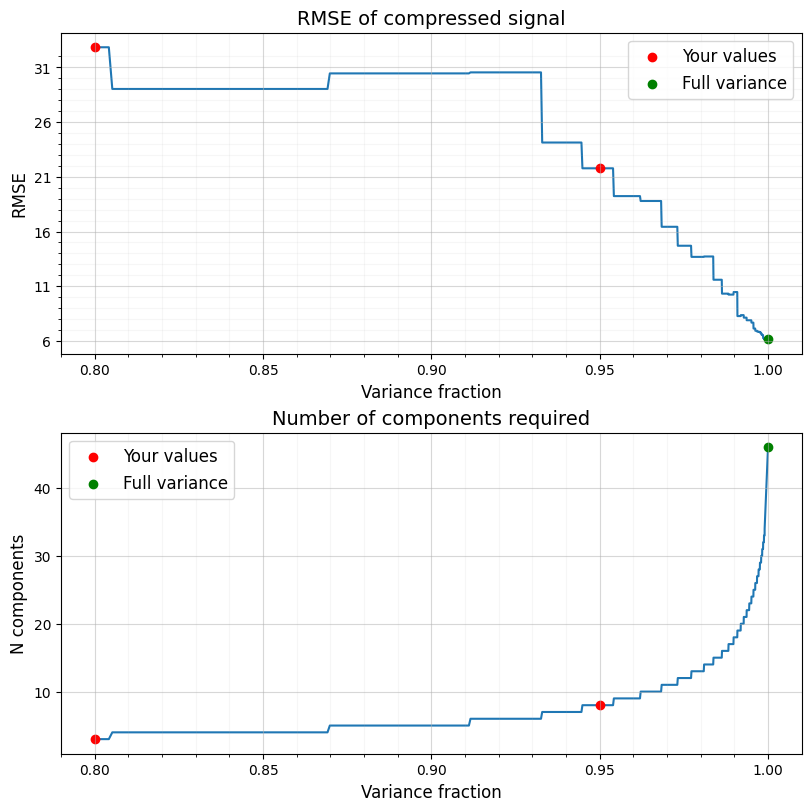

In [31]:
fig3 = plt.figure(figsize=(8,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig3)
ax = fig3.add_subplot(gs[0, :])
ax_n = fig3.add_subplot(gs[1, :])

major_ticks_x = np.arange(0, 1.05, 0.05)
minor_ticks_x = np.arange(0, 1.01,.01)
major_ticks_y = np.arange(int(min(errors_plot)), max(errors_plot), 5)
minor_ticks_y = np.arange(int(min(errors_plot)), max(errors_plot), 1)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax_n.set_xticks(major_ticks_x)
ax_n.set_xticks(minor_ticks_x, minor=True)

ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.5)
ax_n.grid(which='minor', alpha=0.1)
ax_n.grid(which='major', alpha=0.5)

ax.set_xlabel('Variance fraction', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE of compressed signal', fontsize = 14)
ax_n.set_xlabel('Variance fraction', fontsize=12)
ax_n.set_ylabel('N components', fontsize=12)
ax_n.set_title('Number of components required', fontsize = 14)

ax.plot(variance_fractions_plot, errors_plot, zorder = 0)
ax_n.plot(variance_fractions_plot, n_components_plot, zorder = 0)

ax.scatter(variance_fractions, [comp1_error, comp2_error], color = 'r', zorder = 1, label = "Your values")
ax.scatter(1, [nocomp_error], color = 'g', zorder = 1, label = "Full variance")
ax_n.scatter(variance_fractions, [n_components_comp1, n_components_comp2], color = 'r', zorder = 1, label = "Your values")
ax_n.scatter(1, [n_components_nocomp], color = 'g', zorder = 1, label = "Full variance")

ax.legend(fontsize = 12)
ax_n.legend(fontsize = 12)
plt.show()

## 2 - Clustering with DBSCAN

DBSCAN, one of the most popular clustering algorithms, automatically finds the number of clusters based on the local density of the data points.

It is necessary to choose two parameters in order to run DBSCAN:
1. `epsilon`: The radius of local neighborhoods (defined as epsilon-neighborhoods);
2. `MinPts`: Minimum number of points in an epsilon-neighborhood.

We will use the Scikit-Learn implementation of DBSCAN, available here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

### 2.1 - Data Preprocessing

 - This time, we will use a different set of ECG measurements. We will load a sequence of measurements where the first half of the data belongs to a set of anomalous heart-beat events, while the remaining half will correspond to regular heart-beat events.  
 - After data segmentation, we will use a different pre-processing strategy: instead of using the whole signal in the feature matrix, we will actually extract a set of features characterizing the heart beat events. For details about the extracted features you can check the `feature_extract` function implementation available in the `hda_utils.py` file.

In [38]:
ecg_signal = load_dataset_DBSCAN()

# ECG segmentation
fs = 300
feature_mat, segments_list, r_peaks, original_len = segment_ECG2(ecg_signal, fs)

# Normalize data along feature axis - use StandardScaler as before (2 lines of code)
scaler = StandardScaler()
ecg_mat_norm = scaler.fit_transform(feature_mat)

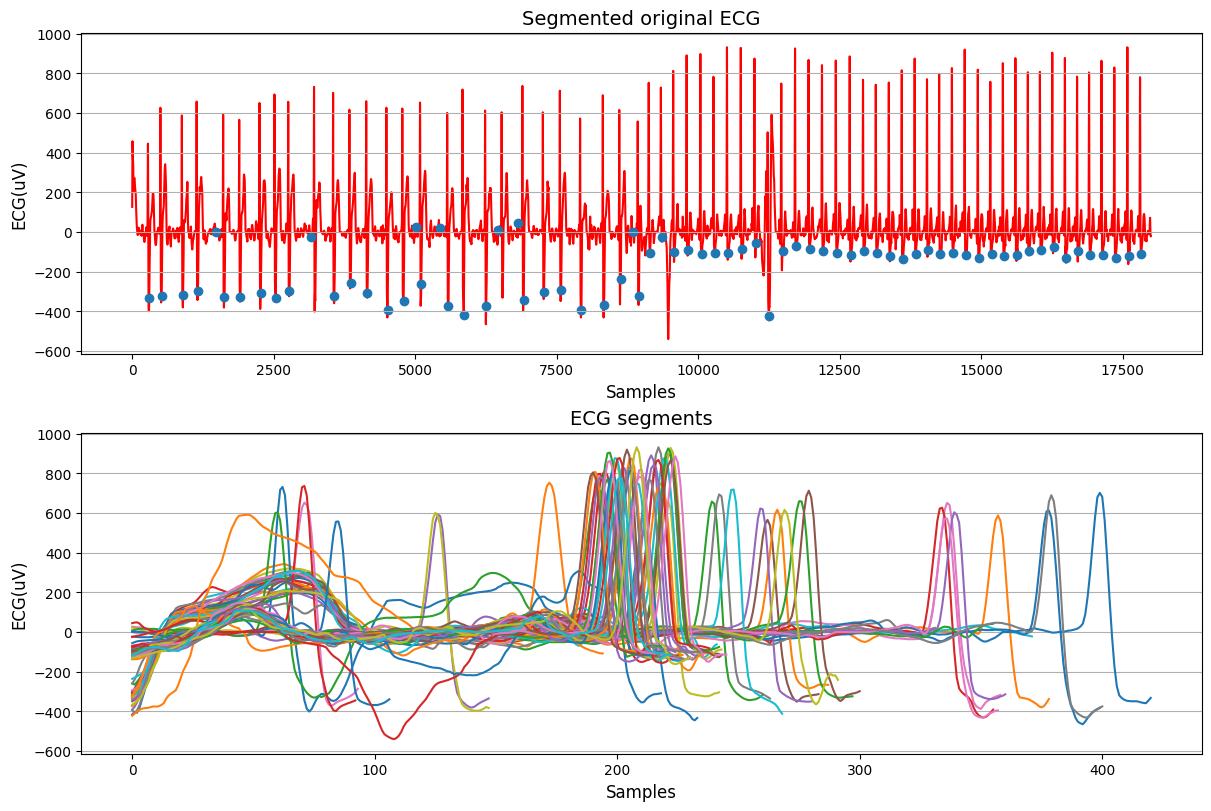

In [39]:
# Plot segments
fig1 = plt.figure(figsize=(12,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig1)
ax1 = fig1.add_subplot(gs[0, :])
ax2 = fig1.add_subplot(gs[1, :])

ax1.plot(ecg_signal, 'r', zorder = 0 )
ax1.scatter(r_peaks, list(ecg_signal[r_peaks].T[0]), zorder = 1)
ax1.set_title('Segmented original ECG', fontsize=14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('ECG(uV)', fontsize=12)
ax1.grid(axis='y')

for segment in segments_list:
    ax2.plot(segment)
# ax2.plot(segments_list)
ax2.set_title('ECG segments', fontsize=14)
ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('ECG(uV)', fontsize=12)
ax2.grid(axis='y')

plt.show()

In [40]:
# Let's apply PCA with 0.9 explained variance
# Let's see how many features are really meaningful for explaining the data
pca2 = PCA(n_components=0.9, svd_solver="full")
# Fit the model on the data ecg_mat_norm
pca2.fit(ecg_mat_norm)
# Apply the transformation to the data ecg_mat_norm
Y_hat = pca2.transform(ecg_mat_norm)

print(pca2.n_components_)
print(pca2.explained_variance_ratio_)

6
[0.37358274 0.22675791 0.11013934 0.08561223 0.06595417 0.04622799]


### 2.2 - Parameter optimization

For the selection of `eps` we will use the technique seen in the theory lectures. Given a fixed value of `MinPts`:
- For each point in the dataset, compute the average distance from all its MinPts-Nearest Neighbors;
- Plot the obtained distances in ascending order;
- Find the knee point of the curve: the y value will be the optimal value of `eps`.

In [42]:
min_points = 10

## Compute the distance matrix using the Euclidean distance - use the np.linalg.norm function
npoints = Y_hat.shape[0]

dist_matrix = np.zeros((npoints, npoints))
for i in range(npoints):
    for j in range(npoints):
        dist_matrix[i,j] = np.linalg.norm(Y_hat[i,:] - Y_hat[j,:])

## For each point compute the average distance from its min_points closest points
avg_dist = np.zeros(npoints)
for i, row in enumerate(dist_matrix):
    # Sort the distances in ascending order (you need this in the next row to select the `min_points` closest points)
    sorted_distances = np.sort(row)
    # Compute the average considering only the `min_points` closest points, i.e., select only the first min_points elements from sorted_distances without considering the first element (that is the point itself)
    avg_dist[i] = np.mean(sorted_distances[1:min_points+1])

## Sort avg_dist
sorted_avg_dist = np.sort(avg_dist)
dists_2d = np.stack([np.arange(1, npoints+1), sorted_avg_dist], axis=1)

# Find the knee point
rotor = Rotor()
rotor.fit_rotate(dists_2d)
elbow_idx = rotor.get_elbow_index()
epsilon = sorted_avg_dist[elbow_idx]

MinPts value: 10; Best value for epsilon: 2.6982900901934324 


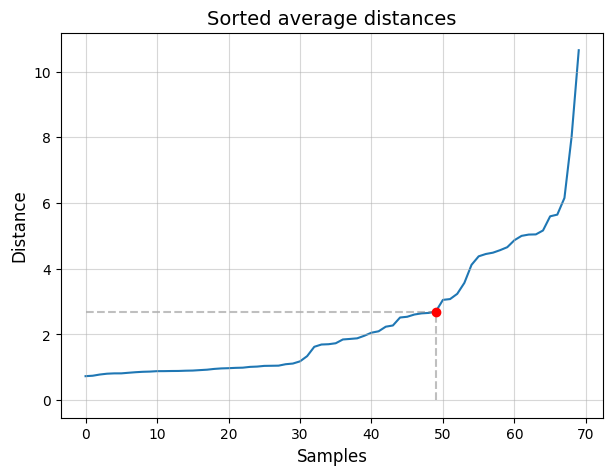

In [43]:
# plot the sorted distances and the knee point
fig7 = plt.figure(figsize=(7,5))
plt.grid(alpha=0.5, zorder=0)
plt.plot(sorted_avg_dist, zorder=1)
plt.scatter(elbow_idx, epsilon, color='r', zorder=2)
plt.hlines(epsilon, 0, elbow_idx, alpha=0.5, color='gray', linestyle='--', zorder=1)
plt.vlines(elbow_idx, 0, epsilon, alpha=0.5,color='gray', linestyle='--', zorder=1)
plt.title('Sorted average distances', fontsize = 14)
plt.xlabel('Samples', fontsize=12)
plt.ylabel('Distance', fontsize=12)

print(f"MinPts value: {min_points}; Best value for epsilon: {str(sorted_avg_dist[elbow_idx])} ")

### 2.3 - Apply DBSCAN algorithm

The syntax is very similar to the `PCA` function:
1. Import the DBSCAN library (already done, see the `import` statements section at the beginning of the notebook)
2. Create a new object of the class with `DBSCAN(...)`: using this class you can specify the parameters `eps` and  `min_samples` (take a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)!). Here, you will input the optimized parameters we found in the above cells.
3. Fit the DBSCAN model on the PCA transformed data (`Y_hat`) using the [fit method](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN.fit): this will return a fitted instance of the `DBSCAN` object.
4. Find the clustering labels in the `labels_` member variable of the `DBSCAN` object instance.

In [44]:
# Run DBSCAN algorithm with the chosen parameters
dbscan = DBSCAN(eps=epsilon, min_samples=min_points)
# `fit` dbscan on Y_hat
dbscan.fit(Y_hat)

# print the number of clusters found
print(f"Number of clusters found by DBSCAN: {len(np.unique(dbscan.labels_))}")

Number of clusters found by DBSCAN: 3


In [45]:
# DBSCAN assigns a cluster label for each point, and -1 if the point is classified as noise
print(dbscan.labels_)

[ 0  0  0 -1 -1  0  0  0  0 -1 -1  0  0  0  0 -1 -1 -1 -1  0  0 -1 -1 -1
  0  0  0  0  0 -1 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


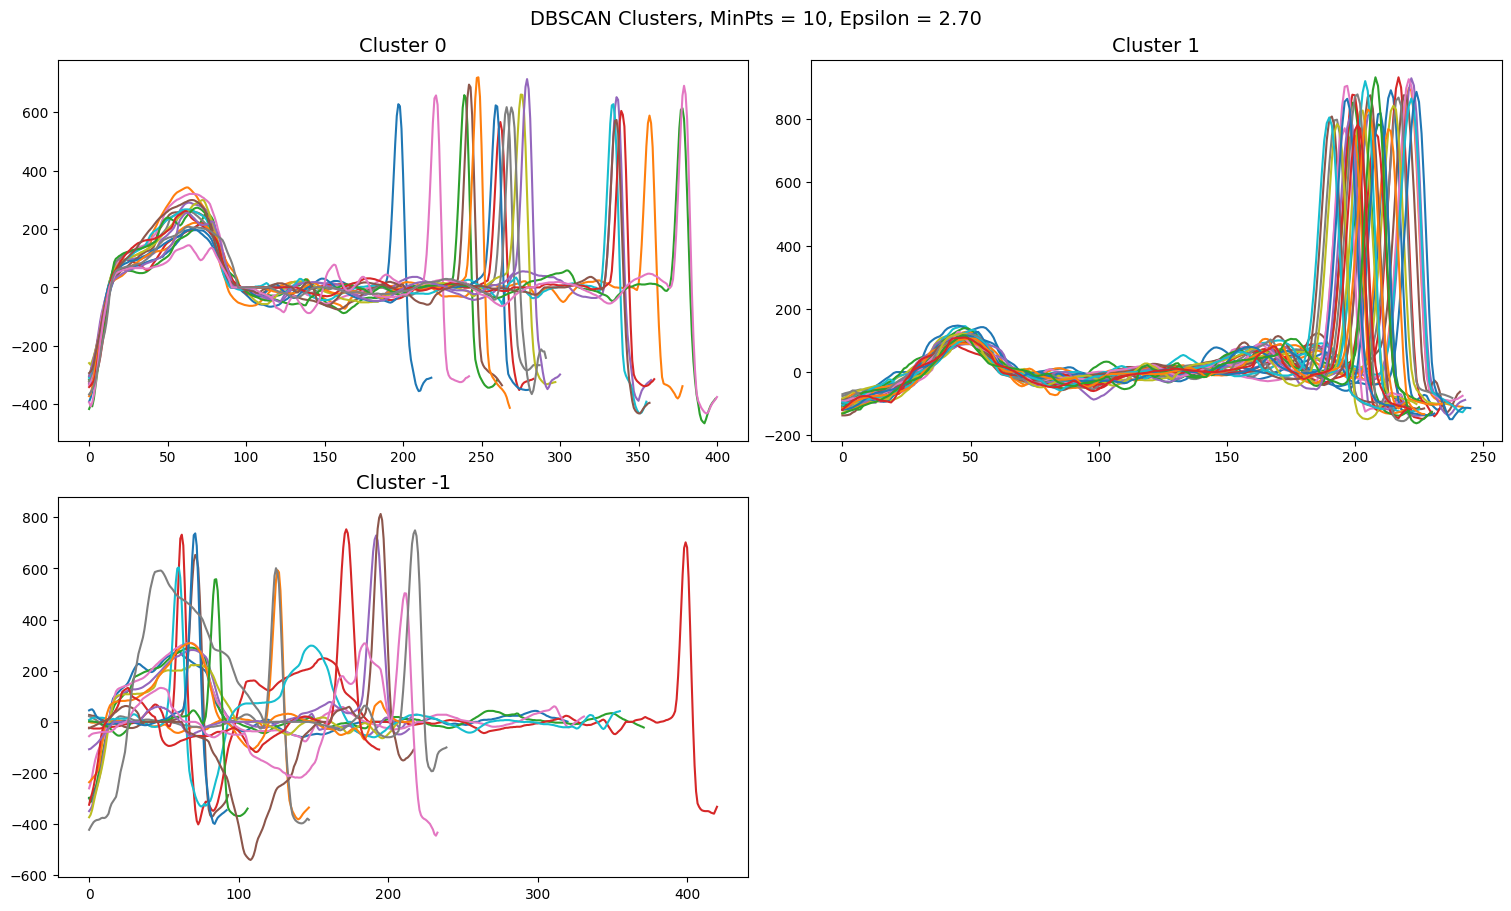

In [46]:
# Plot clusters
nclusters = len(np.unique(dbscan.labels_))

fig5 = plt.figure(figsize=(15,nclusters*3), constrained_layout=True)
gs = GridSpec(nclusters//2+nclusters%2, 2, figure=fig5)

axs = []
for i in range(nclusters):
    axs.append(fig5.add_subplot(gs[i//2, i%2]))

for i in range(Y_hat.shape[0]):
    axs[dbscan.labels_[i]].plot(segments_list[i])
    axs[dbscan.labels_[i]].set_title('Cluster ' + str(dbscan.labels_[i]), fontsize = 14)

plt.suptitle(f"DBSCAN Clusters, MinPts = {min_points}, Epsilon = {epsilon:.2f}", fontsize = 14)
plt.show()

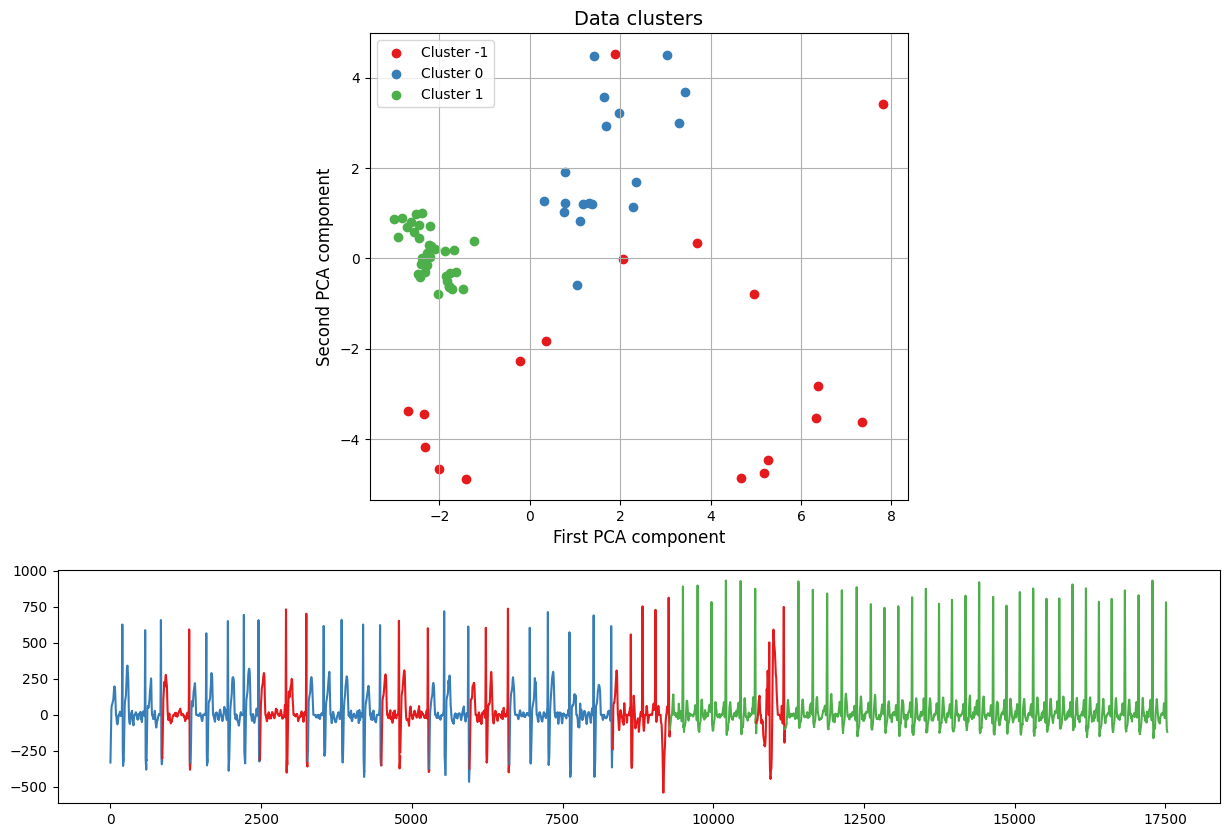

In [47]:
## Visualize the clusters in the PCA space and in the original signal

nclusters = len(np.unique(dbscan.labels_))
labels = dbscan.labels_


fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [2,1]})

cmap = [matplotlib.colormaps['Set1'](i) for i in range(nclusters)]


for l in range(nclusters):
    ax[0].scatter(
        Y_hat[dbscan.labels_+ 1 == l, 0],
        Y_hat[dbscan.labels_ + 1== l, 1],
        color=cmap[l],
        label=f"Cluster {l-1}",
        marker = 'o',
        zorder=1
    )

ax[0].legend()
ax[0].set_title("Data clusters", fontsize = 14)
ax[0].set_xlabel("First PCA component", fontsize = 12)
ax[0].set_ylabel("Second PCA component", fontsize = 12)
ax[0].set_aspect('equal', 'box')
ax[0].grid(0.5, zorder=0)

current_x = 0
for i, segment in enumerate(segments_list):
    ax[1].plot(range(current_x, len(segment) + current_x), segment, color=cmap[labels[i]+1], zorder=1)
    current_x += len(segment)


plt.show()

# Conclusions
Both PCA and clustering techniques can be used for data compression.
In the notebook, we saw that with PCA we can control the number of components or the amount of variance we want to keep.

We applied DBSCAN to automatically obtain the number of clusters based on the similarities among the samples, and we saw how to optimally choose the parameters needed for the method. We tried two clustering approaches: clustering the raw signals and clustering relevant time-domain and frequency-domain features extracted from the signal.
Clustering and PCA can also be combined for dimensionality reduction: clustering in the transformed space may reduce the overall RMSE. Depending on your application you should take into account both the compression error and the computational cost of each approach to design the most appropriate solution to your problem.

You can now play with the notebook modifying it...enjoy! As an example, you can try to apply PCA to the signal you used in the last part of the notebook.